## Uncertainty Quantifications - Monte Carlo Simulations

---

This notebook will quantify log k values for various species using a Monte Carlo method with lower and upper bounds from literature. See below:

Mahoney et al. (2009). Uranyl Adsorption on to Hydrous Ferric Oxcide--A Re-Evaluation for the Diffuse Layer Model Database. *Environmental Science and Technology,* *43*(24), 9263. doi: 10.1021/es901586w

#### Set up initial parameters and uncertainty bounds

*pqcpath*: path to phreeqc.bat executable

*TDBfile*: name of phreeqc database file without file extension

*outfile*: name of phreeqc output file including file extension

*infile*: name of phreeqc input file including file extension

*num_iterations*: controls how many phreeqc runs are done

In [1]:
import os 
import numpy.random
from writeIOphreeqc import*
import matplotlib.pyplot as plt

# these are used when we run phreeqc in MC_sim()
pqcpath = 'C:/Users/htzen/Desktop/phreeqc-3.7.0-15749-x64/bin/phreeqc'
TDBfile = 'llnl_Mahoney_updated'
outfile = 'Outputfile3.out'
infile = 'U_HFO_input3.txt'
num_iterations = 9

# bounds from table 2 in Mahoney et. al.
pars    = ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!']
lower = [1.62, 1.79, 8.75, 15.1]
upper = [5.85, 3.28, 9.32, 15.28]


# extraneous verify function which can be a simple sanity check for longer lists
def verify(low, upp):
    """
    checks length and bounds of lists for correct format
    """
    if len(low) == len(upp):
        
        if all([low[i] <= upp[i] for i in range(len(low))]):
            print("verify: bounds check out")
            return True
        print("error: listed bounds are inconsistent")
        return False
    
    print("error: lists are different lenghts")
    return False



# searches for the '-find ' key in the input file to get the name of the .sel output file
def find_opsel(infile):
    
    with open(infile, 'r') as f:
        for line in f.readlines():
            if line.find("-file ") > 0:
                return line[line.find("-file ")+len("-file "):-1]
            
    print("error: unable to find output file in {}".format(infile))
    return -1

# verify bounds and set phreeqc output to read
verify(lower, upper)
opsel = find_opsel(infile)
opsel

verify: bounds check out


'U_HFO_Complexation_Output_Trial3.sel'

#### Generate values from probablilty distributions

In a Monte Carlo simulation we will generate random values for the parameters within the upper/lower bounds for each run

In [2]:
# import shutil

# some hackey way to save all generated analyte values that I will definitely make
# better in later iterations of my code
# todo: make gen_values a return value so it actually makes sense syntactically 
gen_values = []


# returns a list of random values between lower and upper
def get_random_values(lower, upper):
    values = []
    for i in range(len(lower)):
        values.append(numpy.random.uniform(lower[i], upper[i]))
    return values

# runs num_iterations simulations, assuming initial parameters are set correctly
# requires gen_values to exist and I will fix when my code is outward-facing
def MC_sim(num_iterations, lower, upper):
    # return: list of num_iterations np arrays of [sim#, elem1, elem2...]
    
    obs_all = []
    gen_values.clear()
    for itr in range(num_iterations):
        
        # deletes output.sel and output.txt before each iteration (assume they are in same dir)
        # enabling these steps can help verify phreeqc is correctly generating new output files
#         if os.path.exists("Outputfile.out"):
#             os.remove("Outputfile.out")
#         if os.path.exists("U_HFO_Complexation_Output_Trial3.sel"):
#             os.remove("U_HFO_Complexation_Output_Trial3.sel")

        # generate new values and add to output
        values = get_random_values(lower, upper)
        gen_values.append(values)
#         print(values, itr)
        writeInput(TDBfile, pars, values)
        
        # the .read() here is essential because it tells python to wait for phreeqc to
        # finish running before executing following code.
        os.popen(pqcpath+' '+infile+' '+outfile+' '+TDBfile+'.txt').read()
        
        # reads phreeqc results and appends to running list
        obs = readOutput(opsel, ['pH', 'U'])
        obs_all.append(obs)

        # enabling these lines can help check if the output files are updating correctly
#         shutil.copyfile('U_HFO_Complexation_Output_Trial3.sel', 'U_HFO_Complexation_Output_Trial3_{}.sel'.format(itr))
#         shutil.copyfile('llnl_Mahoney_updated.txt', 'llnl_Mahoney_updated{}.txt'.format(itr))

    return obs_all

res = MC_sim(num_iterations, lower, upper)
#res

#### Plotting + Residual Sum of Squares Analysis with Experimental Results

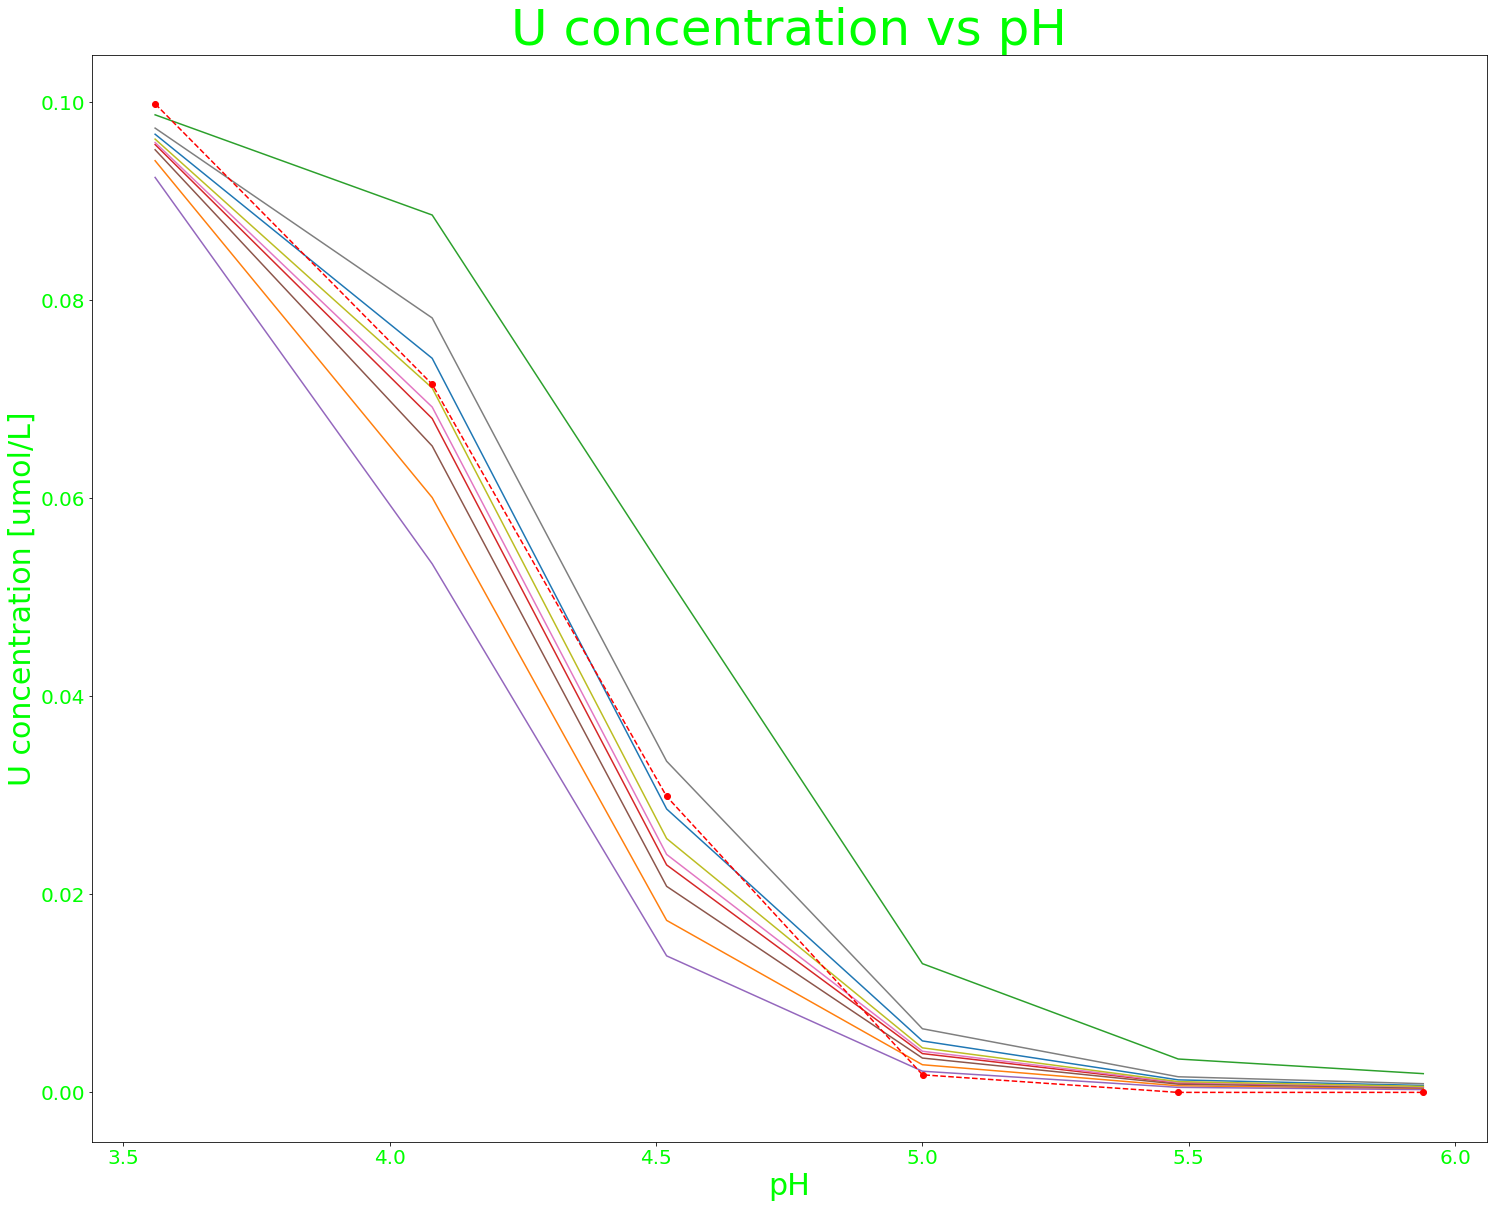

In [3]:
f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("U concentration vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('U concentration [umol/L]', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

# setting up values from experimental results
exp_pH = [3.56041,4.07969,4.51985,5.00029,5.47929,5.93959]
exp_U = [0.099831,0.071537,0.029899,0.001774,0,0]

# plotting each data from MC_sim
for run in res:
    # hard coding in plots for pH and U
    plt.plot(run[1], run[2]*1e6)

# plotting experimental results
plt.plot(exp_pH, exp_U, 'r--o')

plt.show()

For RSS analysis I think the best thing to do in this situation is to just hard-code something instead of making more comprehensive functions, since the experimental data in this case seems tailor-fit for this specific scenario. I will iterate through the list of results and find a quick residual sum of squares for each pH (approximating the pHes because they're already really close)

In [4]:
rss_list = []

for run in res:
    # rss is Sum((expected - observed)^2)
    rss = np.sum(np.square(exp_U - run[2]*1e6))
    rss_list.append(rss)

bestrun = rss_list.index(min(rss_list))
bestfit = res[rss_list.index(min(rss_list))][2]
bestanalytes = gen_values[bestrun]

print(rss_list)
print(min(rss_list), bestrun)
print("The best fitting analytes are: {} from run {}.".format(bestanalytes, bestrun))

# write a new .tpl file with the best fit analyte values
writeInput(TDBfile, pars, bestanalytes, TDBfile+"_MCnew")

[3.1529999748399994e-05, 0.00032246345341560014, 0.0009323841862099994, 8.253441773170001e-05, 0.0006444278543406004, 0.00014677007697679986, 6.187052770000003e-05, 8.811027566000003e-05, 3.9832473936900034e-05]
3.1529999748399994e-05 0
The best fitting analytes are: [3.4455824908907937, 2.841972464466615, 9.123273621444472, 15.107021920356352] from run 0.
